In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
    'olist_orders_delivered_clean.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

df_orders      = read_olist_csv('../data/olist_orders_dataset.csv')
df_customers   = read_olist_csv('../data/olist_customers_dataset.csv')
df_items       = read_olist_csv('../data/olist_order_items_dataset.csv')
df_payments    = read_olist_csv('../data/olist_order_payments_dataset.csv')
df_reviews     = read_olist_csv('../data/olist_order_reviews_dataset.csv')
df_products    = read_olist_csv('../data/olist_products_dataset.csv')
df_prod_cat_tr = read_olist_csv('../data/product_category_name_translation.csv')
df_sellers     = read_olist_csv('../data/olist_sellers_dataset.csv')
df_geo         = read_olist_csv('../data/olist_geolocation_dataset.csv')

# Cleaned dataset
df_orders_delivered_clean = read_olist_csv('../data/cleaned_data/olist_orders_delivered_clean.csv')

In [5]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


## Effect on Customer Retention

In [11]:
# 1. Bring the unique ID into orders table
df_orders_merge_customers = (
    df_orders_delivered_clean
    .merge(
        df_customers[['customer_id','customer_unique_id']],
        on='customer_id',
        how='left'
    )
)

# 2. Count how many orders each unique customer made
order_counts = (
    df_orders_merge_customers
    .groupby('customer_unique_id')['order_id']
    .nunique()    # or .count(), since order_id is unique per row
)

# 3. How many customers only ordered once?
single_order = (order_counts == 1).sum()

# 4. How many customers ordered more than once?
multiple_orders = (order_counts > 1).sum()

print(f"{single_order:,} customers completed exactly one order")
print(f"{multiple_orders:,} customers completed more than one order")

90,372 customers completed exactly one order
2,796 customers completed more than one order


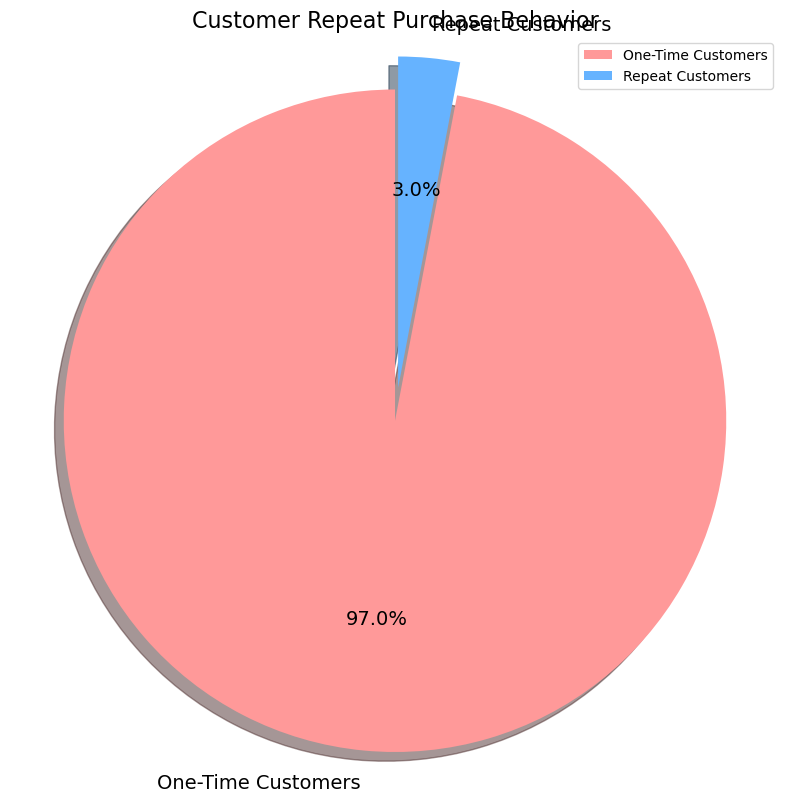

Total unique customers: 93,168
One-time customers: 90,372 (97.0%)
Repeat customers: 2,796 (3.0%)
Repeat customer ratio: 3.00%


In [12]:
# Create a pie chart to visualize the distribution of repeat vs one-time customers
labels = ['One-Time Customers', 'Repeat Customers']
sizes = [single_order, multiple_orders]
colors = ['#ff9999', '#66b3ff']
explode = (0, 0.1)  # explode the 2nd slice (repeat customers)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=90, textprops={'fontsize': 14})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Customer Repeat Purchase Behavior', fontsize=16)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

# Print some additional statistics
total_customers = single_order + multiple_orders
repeat_ratio = multiple_orders / total_customers * 100

print(f"Total unique customers: {total_customers:,}")
print(f"One-time customers: {single_order:,} ({single_order/total_customers*100:.1f}%)")
print(f"Repeat customers: {multiple_orders:,} ({multiple_orders/total_customers*100:.1f}%)")
print(f"Repeat customer ratio: {repeat_ratio:.2f}%")

Customer retention is still 3% on cleaned orders data

### How does Late Deliveries affect Customer Retention?

In [22]:
df = df_orders_delivered_clean.copy()

# lateness (days)  (+ = late, ≤0 = early/on-time)
df['late_days'] = (
    df['order_delivered_customer_date'] -
    df['order_estimated_delivery_date']
).dt.days

df['is_late'] = df['late_days'] > 0
df[df['is_late']].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,late_days,is_late
19,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,11,True
24,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12,9,True
40,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,7,True
55,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02,1,True
56,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,7,True


In [23]:
df = df.merge(
    df_customers[['customer_id','customer_unique_id']],
    on='customer_id',
    how='left'
)

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,late_days,is_late,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,False,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,False,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,False,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,False,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,False,72632f0f9dd73dfee390c9b22eb56dd6


In [25]:
# aggregate to one row per customer
cust = (
    df
    .groupby('customer_unique_id')
    .agg(
        total_orders = ('order_id', 'nunique'),
        late_orders  = ('is_late',  'sum')
    )
    .assign(
        # True if they ever came back
        repeat_customer = lambda x: x['total_orders'] > 1,
        # True if they ever got a late delivery
        ever_late       = lambda x: x['late_orders'] > 0,
        # severity: share of their orders that were late
        late_ratio      = lambda x: x['late_orders'] / x['total_orders']
    )
    .reset_index()
)

cust.head()

,customer_unique_id,total_orders,late_orders,repeat_customer,ever_late,late_ratio
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,False,False,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,False,False,0.0
2,0000f46a3911fa3c0805444483337064,1,0,False,False,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,False,False,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,0,False,False,0.0


In [34]:
first_orders = (
    df.sort_values('order_purchase_timestamp')
      .drop_duplicates('customer_unique_id', keep='first')
      .loc[:, ['customer_unique_id', 'is_late']]
      .rename(columns={'is_late':'first_late'})
)

# merge first_late back to cust-level frame
cust2 = cust.merge(first_orders, on='customer_unique_id')

In [35]:
first_orders.head()

,customer_unique_id,first_late
29746,830d5b7aaa3b6f1e9ad63703bec97d23,True
90328,32ea3bdedab835c3aa6cb68ce66565ef,False
27537,2f64e403852e6893ae37485d5fcacdaf,False
94871,61db744d2f835035a5625b59350c6b63,False
85657,8d3a54507421dbd2ce0a1d58046826e0,False


In [36]:
cust2.head()

,customer_unique_id,total_orders,late_orders,repeat_customer,ever_late,late_ratio,first_late
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,False,False,0.0,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,False,False,0.0,False
2,0000f46a3911fa3c0805444483337064,1,0,False,False,0.0,False
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,False,False,0.0,False
4,0004aac84e0df4da2b147fca70cf8255,1,0,False,False,0.0,False


In [37]:
repeat_by_first_late = (
    cust2.groupby('first_late')['repeat_customer']
         .mean()
         .rename('repeat_rate')
)
print((repeat_by_first_late*100).round(2))

first_late
False    3.04
True     2.50
Name: repeat_rate, dtype: float64


In [38]:
# build contingency table: rows=first_late, cols=repeat_customer
contingency = pd.crosstab(cust2['first_late'], cust['repeat_customer'])

chi2, p, _, _ = ss.chi2_contingency(contingency)

print(contingency)
print(f"Chi² = {chi2:.2f}, p = {p:.4f}")

repeat_customer  False  True 
first_late                   
False            84179   2637
True              6193    159
Chi² = 5.62, p = 0.0177
